<h1> Loss: Mean Absolute Percentage Error </h1>

As the notebook "stage2_sum_input" proposes I'd like to try an other loss function to penalize all wrong values with the same weight.

In [ ]:
import myfunctions as mf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time
from scipy.optimize import curve_fit

In [2]:
# load data
rootfile = uproot.open("./stage2_clusters.root")
event = rootfile["user202302;1"]
xMC = event["x_MC"].array(library="np") #[:40000]
yMC = event["y_MC"].array(library="np") #[:40000]
EMC = event["E_MC"].array(library="np") #[:40000]
x_truth = event["x_truth"].array(library="np") #[:40000]
y_truth = event["y_truth"].array(library="np") #[:40000]
E_truth = event["E_truth"].array(library="np") #[:40000]
x_fit = event["x_fit"].array(library="np") #[:40000]
y_fit = event["y_fit"].array(library="np") #[:40000]
E_fit = event["E_fit"].array(library="np") #[:40000]

In [3]:
clustersNxN, coord, ind_del = mf.form_cluster(xMC, yMC, EMC)

This took  166.26897025108337 s


In [4]:
clusters = clustersNxN.reshape((clustersNxN.shape[0], 25))
# cut data and from trainings and test data
xMC_train, xMC_veri, yMC_train, yMC_veri, EMC_train, EMC_veri, x_truth_train, x_truth_veri, y_truth_train, y_truth_veri, E_truth_train, E_truth_veri, x_fit_veri, y_fit_veri, E_fit_veri, clusters_t, clusters_v, coord_t, coord_v = mf.training_and_validation_data(xMC, yMC, EMC, x_truth, y_truth, E_truth, x_fit, y_fit, E_fit, ind_del, clusters, coord)

# prep data
training = mf.prep_trainingsdata(x_truth_train, y_truth_train, E_truth_train, coord_t)
veri_truth_data = mf.prep_trainingsdata(x_truth_veri, y_truth_veri, E_truth_veri, coord_v)
veri_fit_data = mf.prep_trainingsdata(x_fit_veri, y_fit_veri, E_fit_veri, coord_v)

# standardize input
clusters_t = mf.standardscore(clusters_t)
clusters_v = mf.standardscore(clusters_v)

Now define model with new loss function. Use [this](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/) for decaying learning rate.

In [61]:
'''
initial_learning_rate = 0.00001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.80,
    staircase=True)
'''

initial_learning_rate = 0.00001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.80)

model19 = keras.Sequential([layers.Input(shape=(25)),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(32, activation="relu"),
                         layers.Dense(3, activation=None)])
model19.summary()



model19.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), 
                optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 64)                1664      
_________________________________________________________________
dense_162 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_163 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_164 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_165 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_166 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_167 (Dense)            (None, 3)               

In [62]:
a = time.time()
fit_hist = model19.fit(clusters_t, training, batch_size=64, epochs=20, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/20
8482/8482 [==============================] - 7s 843us/step - loss: 475.6959 - val_loss: 44.9451
Epoch 2/20
8482/8482 [==============================] - 7s 837us/step - loss: 526.0564 - val_loss: 32.4072
Epoch 3/20
8482/8482 [==============================] - 7s 835us/step - loss: 437.0274 - val_loss: 23.6016
Epoch 4/20
8482/8482 [==============================] - 7s 837us/step - loss: 323.5670 - val_loss: 16.1391
Epoch 5/20
8482/8482 [==============================] - 7s 840us/step - loss: 263.9375 - val_loss: 14.8545
Epoch 6/20
8482/8482 [==============================] - 7s 843us/step - loss: 220.8274 - val_loss: 14.0776
Epoch 7/20
8482/8482 [==============================] - 7s 838us/step - loss: 184.3290 - val_loss: 13.5511
Epoch 8/20
8482/8482 [==============================] - 7s 837us/step - loss: 158.2913 - val_loss: 13.0931
Epoch 9/20
8482/8482 [==============================] - 7s 860us/step - loss: 138.2494 - val_loss: 12.7561
Epoch 10/20
8482/8482 [==============

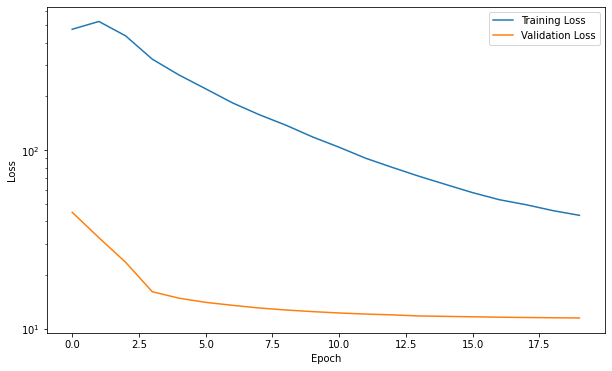

In [63]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist)

In [64]:
a = time.time()
fit_hist1 = model19.fit(clusters_t, training, batch_size=64, epochs=20, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/20
8482/8482 [==============================] - 7s 844us/step - loss: 40.9690 - val_loss: 11.4844
Epoch 2/20
8482/8482 [==============================] - 7s 843us/step - loss: 39.3852 - val_loss: 11.4549
Epoch 3/20
8482/8482 [==============================] - 7s 845us/step - loss: 38.0950 - val_loss: 11.4380
Epoch 4/20
8482/8482 [==============================] - 7s 871us/step - loss: 36.7599 - val_loss: 11.4251
Epoch 5/20
8482/8482 [==============================] - 7s 872us/step - loss: 35.6501 - val_loss: 11.4136
Epoch 6/20
8482/8482 [==============================] - 7s 874us/step - loss: 34.7689 - val_loss: 11.4046
Epoch 7/20
8482/8482 [==============================] - 7s 873us/step - loss: 34.0887 - val_loss: 11.3954
Epoch 8/20
8482/8482 [==============================] - 7s 874us/step - loss: 33.5120 - val_loss: 11.3895
Epoch 9/20
8482/8482 [==============================] - 7s 847us/step - loss: 33.0395 - val_loss: 11.3845
Epoch 10/20
8482/8482 [=======================

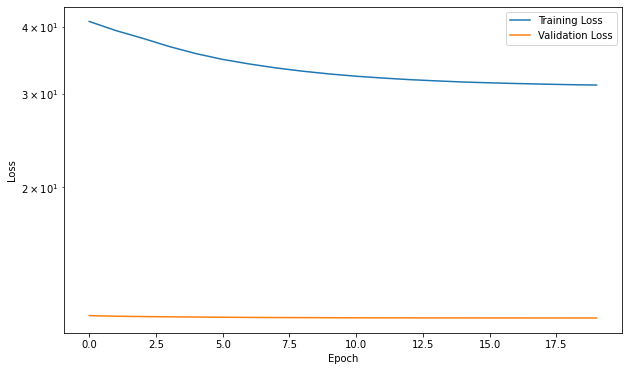

In [66]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist1)

In [19]:
a = time.time()
fit_hist1 = model5.fit(clusters_t, training, batch_size=64, epochs=180, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/180
8482/8482 [==============================] - 7s 839us/step - loss: 26.3075 - val_loss: 8.4542
Epoch 2/180
8482/8482 [==============================] - 7s 849us/step - loss: 23.0249 - val_loss: 8.2552
Epoch 3/180
8482/8482 [==============================] - 7s 838us/step - loss: 34.4798 - val_loss: 8.1363
Epoch 4/180
8482/8482 [==============================] - 7s 840us/step - loss: 20.3479 - val_loss: 7.9589
Epoch 5/180
8482/8482 [==============================] - 7s 842us/step - loss: 40.8054 - val_loss: 7.9100
Epoch 6/180
8482/8482 [==============================] - 7s 845us/step - loss: 18.7267 - val_loss: 7.7491
Epoch 7/180
8482/8482 [==============================] - 7s 844us/step - loss: 44.5191 - val_loss: 7.7806
Epoch 8/180
8482/8482 [==============================] - 7s 845us/step - loss: 15.1685 - val_loss: 7.5445
Epoch 9/180
8482/8482 [==============================] - 7s 846us/step - loss: 50.4134 - val_loss: 7.5275
Epoch 10/180
8482/8482 [======================

KeyboardInterrupt: 

In [20]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist1)

NameError: name 'fit_hist1' is not defined

In [ ]:
output = model1.predict(clusters_v)

In [ ]:
mf.histo_output(output.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x")

In [ ]:
mf.histo_output(output.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

In [ ]:

def gaus(x, mu, sigma, A):
    return (A/np.sqrt(2*np.pi * sigma**2))* np.exp(-(x-mu)**2 / (2*sigma**2))

def histo_output_rel(arr_NN, arr_fit, arr_truth, name='', figsave=False, range_x = (-1,1), bins=300, fit=True):
    '''takes output of neural network (either x,y OR E), the fit values (either x,y, OR E) and the true values of e,y or E. 
    Define with name which parameter (x,y,E) you gave as input'''
    
    plt.rcParams["figure.figsize"] = (10,6)
    plt.subplot(2,1,1)
    n_counts, bins, patches = plt.hist((arr_NN-arr_truth)/arr_truth, bins=bins, range=range_x)
    # fit
    if fit==True:
        maxv = n_counts.max()
        ind_fit = np.where(n_counts > 0.3*maxv)
        liml = ind_fit[0].min()
        limu = ind_fit[0].max() + 1

        x_centers = 0.5*(bins[:-1]+bins[1:])
        popt1, pcov1 = curve_fit(gaus, x_centers[liml:limu], n_counts[liml:limu], p0=[0,1, 100], sigma=1/np.sqrt(n_counts)[liml:limu], maxfev=10000)
        perr1 = np.sqrt(np.diag(pcov1))
        x_fit = np.linspace(x_centers[liml:limu][0], x_centers[liml:limu][-1], 500)
        y_fit = gaus(x_fit, *popt1)
        plt.plot(x_fit, y_fit, 'r--', label="Gaussian fit with " + r"$\mu = ({:.3f} \pm {:.3f})$".format(popt1[0], perr1[0]) + ", " + r"$\sigma = ({:.3f} \pm {:.3f})$".format(popt1[1], perr1[1]))
        plt.legend()
        plt.xlabel("relative difference of true and predicted value of " + name)
        plt.ylabel("counts")
        
        # which values does NN not learn correctly (energy)?
        ind_bad = np.where(abs((arr_NN-arr_truth)/arr_truth) > popt1[1]) # all events further away than 1 sigma
        values_bad = arr_NN[ind_bad]
    
    plt.subplot(2,1,2)
    n_counts, bins, patches = plt.hist((arr_fit-arr_truth)/arr_truth, bins=bins, range=range_x)

    
    if fit==True:
        # fit
        maxv = n_counts.max()
        ind_fit = np.where(n_counts > 0.3*maxv)
        liml = ind_fit[0].min()
        limu = ind_fit[0].max() + 1

        x_centers = 0.5*(bins[:-1]+bins[1:])
        popt2, pcov2 = curve_fit(gaus, x_centers[liml:limu], n_counts[liml:limu], p0=[0,1, 100], sigma=1/np.sqrt(n_counts)[liml:limu], maxfev=10000)
        perr2 = np.sqrt(np.diag(pcov2))
        x_fit = np.linspace(x_centers[liml:limu][0], x_centers[liml:limu][-1], 500)
        y_fit = gaus(x_fit, *popt2)
        plt.plot(x_fit, y_fit, 'r--', label="Gaussian fit with " + r"$\mu = ({:.3f} \pm {:.3f})$".format(popt2[0], perr2[0]) + ", " + r"$\sigma = ({:.3f} \pm {:.3f})$".format(popt2[1], perr2[1]))
        plt.legend()
        plt.xlabel("relative difference of true and coral fit value of " + name)
        plt.ylabel("counts")
    
    plt.tight_layout()
    if figsave == True:
        plt.savefig(name+"_histo.pdf")
    plt.show()
    
    if fit==True:
        #return popt1, perr1, popt2, perr2 
        return values_bad

In [ ]:
E_bad = histo_output_rel(output.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-0.25,0.25), fit=True)

In [ ]:
plt.hist(E_bad, bins=50)
plt.title("Energies that are more than one $\sigma$ away from true value")
print(E_bad.shape, output.T[2].shape)